<a href="https://colab.research.google.com/github/Raychanan/ray_content_final_project/blob/main/content_final_week4_classification_SUBMIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Raychanan/ray_content_final_project
!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

Cloning into 'ray_content_final_project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 9), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.
  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-artpw7wj
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-artpw7wj
     |████████████████████████████████| 5.5MB 4.8MB/s 
     |████████████████████████████████| 122kB 42.9MB/s 
     |████████████████████████████████| 163kB 42.3MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 32.8MB 120kB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 5.1MB 43.4MB/s 
     |█████████████████████████

In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import pandas as pd
import seaborn as sns
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [ ]:
covid_df = pd.read_csv("/content/ray_content_final_project/Corona_NLP_train_utf8.csv", header=0)

covid_df.dropna(inplace=True) # dropna
# now_df.drop("Unnamed: 0", axis=1, inplace=True) # drop column
covid_df.rename(columns={'OriginalTweet':'text', "Sentiment":'sentiment'}, inplace=True) #renmae column

covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃœT: 36.319708,-82.363649",16-03-2020,As news of the regionÂ’s first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂ’all really shitting that much more at home?...,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative
41150,44949,89901,OHIO,14-04-2020,I never that weÂ’d be in a situation &amp; wor...,Positive
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral


In [ ]:
covid_df['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative', 'Extremely Positive',
       'Extremely Negative'], dtype=object)

In [ ]:
covid_df = covid_df.sample(n=5000, random_state=123)

Tokenize and normalize

In [ ]:
covid_df['tokenized_text'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_text'] = covid_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

It's a DataFrame! and it looks like this:

In [ ]:
covid_df.head()

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_text,normalized_text
8048,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[Gas, prices, dropping, to, record, lows, with...","[gas, price, drop, record, low, place, covid19..."
23223,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,"[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID,...","[sale, face, mask, 3ply, n95, rapid, covid-19,..."
19704,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,"[The, impact, of, COVID-19, is, reaching, all,...","[impact, covid-19, reach, way, gas, tank, pric..."
17988,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,"[3x, as, many, consumers, are, worried, about,...","[3x, consumer, worry, dye, covid-19, lose, job..."
14393,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,"[How, much, toiletpaper, is, enough, coronavir...","[toiletpaper, coronavirus, https://t.co/lqszyf..."


Neat! Let's turn the 'sentiment' column into a binary category variable.

In [ ]:
covid_df['category'] = [s == 'Neutral' for s in covid_df['sentiment']]

Tokenize and normalize

In [ ]:
covid_df['tokenized_text'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_text'] = covid_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

4000
1000


# Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [ ]:
TFVects.shape

(4000, 5414)

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


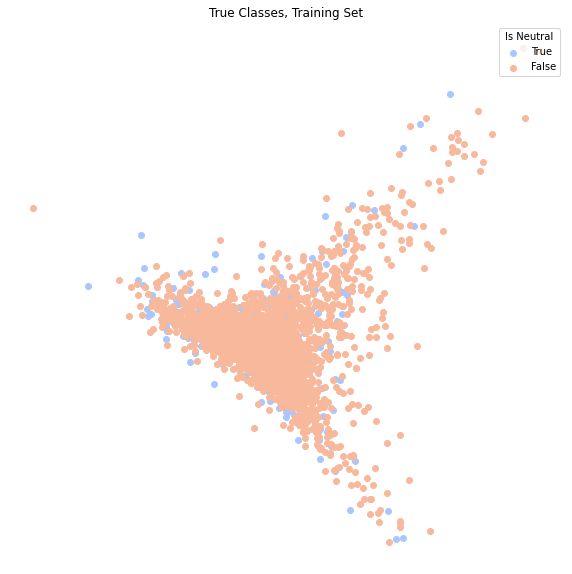

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Neutral
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Neutral
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Neutral')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish "Neutral" very well. Let's perform a screeplot to see how many Principal Components we need.

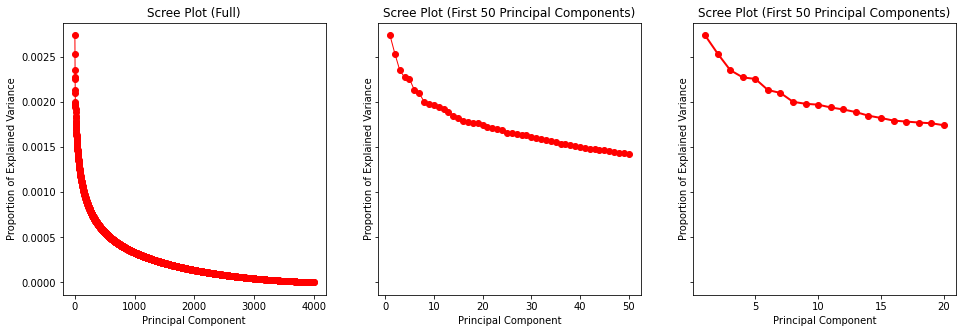

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how logistic regression performs on the training dataset of our developed model. The result:80%

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.805

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.802

Even better! How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.80525
Testing:
0.804


Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.80575
Testing:
0.802


Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.80625
Testing:
0.803


This is becoming ridiculous (400)

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.80925
Testing:
0.803


It's clear that adding dimensions doesn't lead to a greater improvement

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8145


Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.801


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [ ]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.87975
Testing:
0.793


It's even a little worse than logit. What about other measures? We start by saving the predictions in the data frame to save the time of re-running the model each time.

In [ ]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [ ]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.3333333333333333

Recall:

In [ ]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.045454545454545456

F1-measure:

In [ ]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.08

Let's take a look at how well our posterior distribution looks relative to the truth.

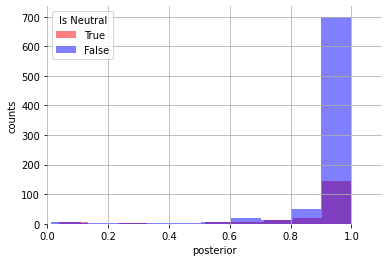

In [ ]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Neutral")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

This classification is surprisingly accurate. We can even use some simple math to see which words have the most impact

In [ ]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Neutral' : [],
    'Neutral_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Neutral'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Neutral_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Neutral,Neutral_log_prob,Clinton,Clinton_log_prob
0,good,-3.533531,socialdistancing,-3.110336
1,stop,-3.577016,outbreak,-3.298388
2,safe,-3.599489,essential,-3.369847
3,price,-3.634175,behavior,-3.574641
4,world,-3.634175,market,-3.574641
5,health,-3.670107,health,-3.721245
6,virus,-3.682377,impact,-3.721245
7,working,-3.682377,march,-3.721245
8,employees,-3.694799,quarantine,-3.721245
9,spread,-3.694799,customers,-3.775312


# Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? 

In [ ]:
covid_df['category'] = covid_df['sentiment']
covid_df.head()

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_text,normalized_text,category
8048,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[Gas, prices, dropping, to, record, lows, with...","[gas, price, drop, record, low, place, covid19...",Negative
23223,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,"[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID,...","[sale, face, mask, 3ply, n95, rapid, covid-19,...",Extremely Positive
19704,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,"[The, impact, of, COVID-19, is, reaching, all,...","[impact, covid-19, reach, way, gas, tank, pric...",Positive
17988,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,"[3x, as, many, consumers, are, worried, about,...","[3x, consumer, worry, dye, covid-19, lose, job...",Negative
14393,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,"[How, much, toiletpaper, is, enough, coronavir...","[toiletpaper, coronavirus, https://t.co/lqszyf...",Neutral


We can pick specific categories, and pull the relevant training and testing sets. 

'Neutral', 'Positive', 'Negative', 'Extremely Positive',
       'Extremely Negative']

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_ng_df))
print(len(test_ng_df))

4000
1000


We need to extract features from the text. 

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [ ]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [ ]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.71275


In [ ]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
26387,Extremely Positive,Positive
30764,Neutral,Negative
35716,Positive,Positive
26032,Positive,Positive
39679,Neutral,Neutral
33150,Negative,Positive
19014,Extremely Positive,Extremely Positive
1037,Negative,Positive
4988,Extremely Positive,Positive
19597,Negative,Negative


Looks pretty good, lets examine the testing dataset:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.357


Sadly, it's not very effective.

We can even use a confusion matrix

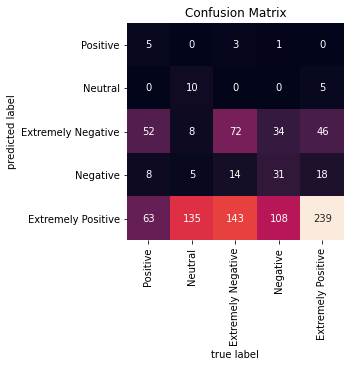

In [ ]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

This also validates the results in logistic regression:good classification of the neutrality class

Let's calculate the precision, recall, and F-measures.

In [ ]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.43320476753167103
0.357
0.29381946593460784


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [ ]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.127,0.517238,0.555556,0.144701,0.039062
Extremely Positive,0.153,0.528676,0.666667,0.190194,0.063291
Positive,0.518,0.563565,0.347384,0.338561,0.775974
Neutral,0.188,0.561841,0.407895,0.215671,0.178161
Negative,0.300,0.564027,0.339623,0.265400,0.310345


The results are interesting, and it is clear that the model is very accurate in classifying extreme and neutral emotions

We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

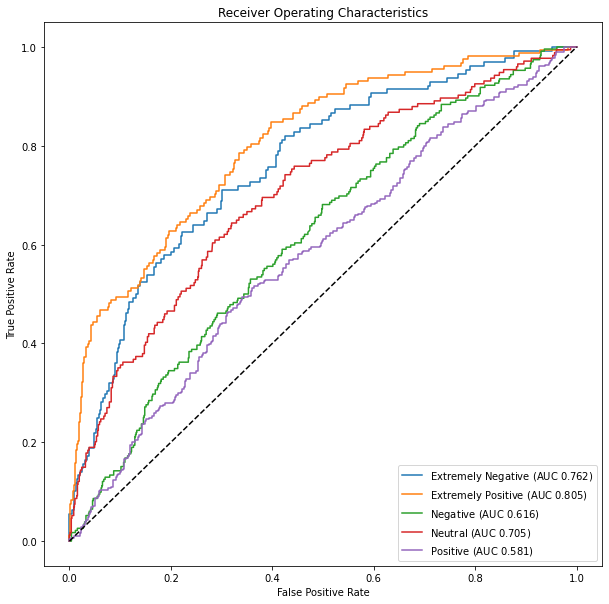

In [ ]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

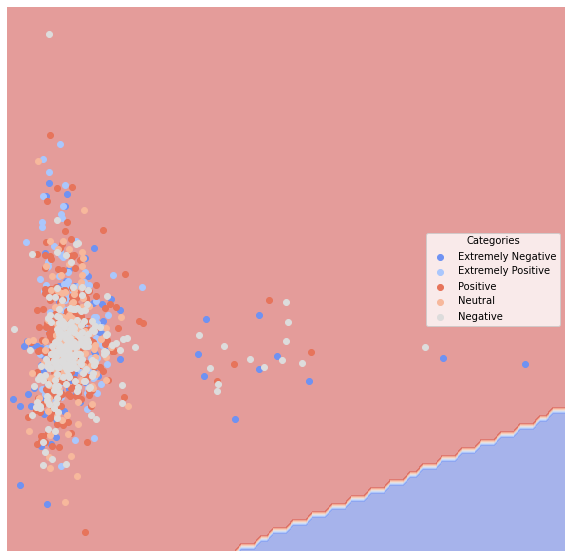

In [ ]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

# Decision Trees

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

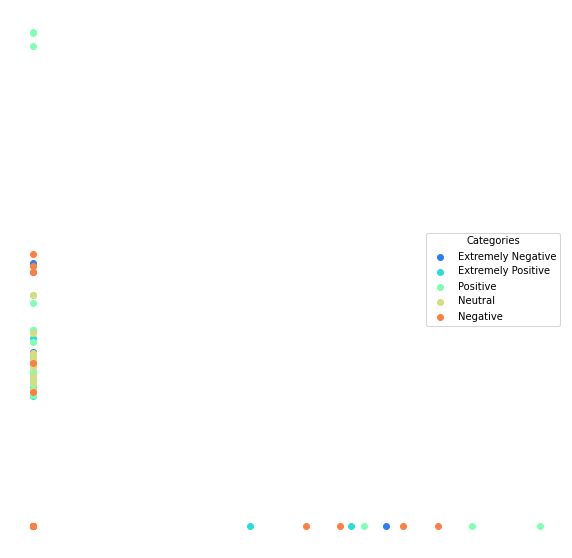

In [ ]:

lucem_illud.plotter(train_ng_df)

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

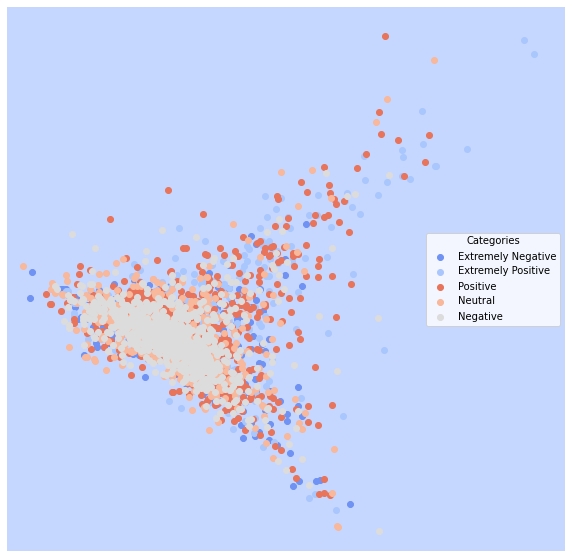

In [ ]:
lucem_illud.plotregions(clf_tree, train_ng_df)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, test_ng_df)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.129,0.499427,0.000000,0.128000,0.000000
Extremely Positive,0.152,0.593539,0.546875,0.244143,0.221519
Positive,0.671,0.495355,0.305882,0.306034,0.928571
Neutral,0.174,0.500000,0.000000,0.174000,0.000000
Negative,0.232,0.500000,0.000000,0.232000,0.000000


Consistent with previous findings:Good classification of extreme and neutral emotions

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(test_ng_df['category'],clf_tree.predict(np.stack(test_ng_df['vect'], axis = 0)))

0.321

It doesn't work well.

What would happen if we pruned this tree?

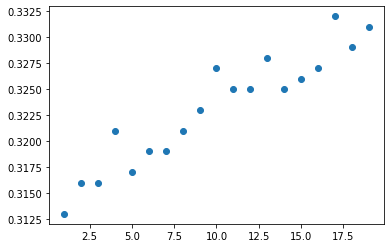

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['category'])
    score = sklearn.metrics.accuracy_score(test_ng_df['category'], tree2.predict(np.stack(test_ng_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can choose a different layer of the decision tree or "prune" it. The shape in the decision tree has been a bit strange, which suggests that our model goes beyond these 18 layers

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

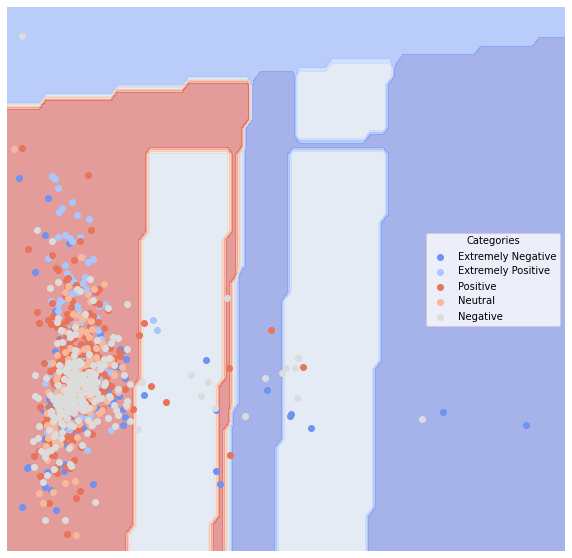

In [ ]:
lucem_illud.plotregions(bag, test_ng_df)

In [ ]:
lucem_illud.evaluateClassifier(bag, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.129,0.549419,0.483871,0.169704,0.117188
Extremely Positive,0.152,0.652665,0.527273,0.293556,0.367089
Positive,0.627,0.500122,0.308063,0.308052,0.831169
Neutral,0.177,0.511793,0.400000,0.181793,0.034483
Negative,0.229,0.513986,0.615385,0.245220,0.034483


But the results still haven't improved much

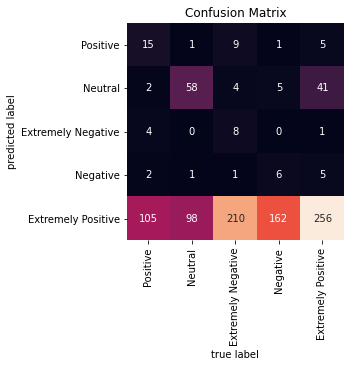

In [ ]:
lucem_illud.plotConfusionMatrix(bag, test_ng_df)

The conclusion is consistent with the previous

# K-Nearest Neighbors

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.13450,0.5,0.00000,0.13450,0.0
Extremely Positive,0.15600,0.5,0.00000,0.15600,0.0
Positive,0.28650,0.5,0.00000,0.28650,0.0
Neutral,0.80475,0.5,0.19525,0.19525,1.0
Negative,0.22775,0.5,0.00000,0.22775,0.0


Let's take a look at the test data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2


The results of this test are still pretty bad

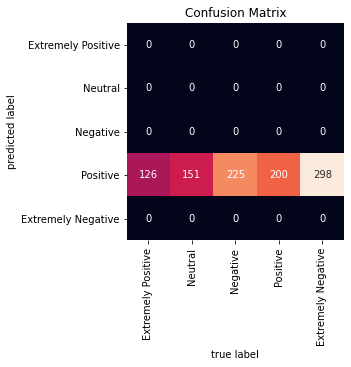

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

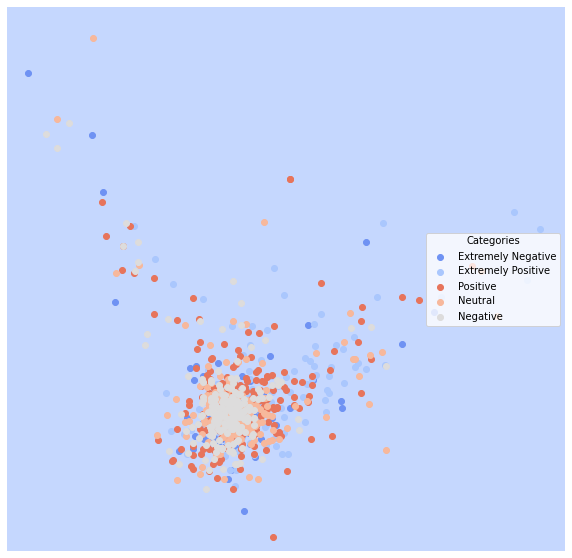

In [ ]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

# SVMs

Initilize the model and make a train test split:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in covid_df['normalized_text']])
covid_df['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

In [ ]:
holdBackFraction = .2
train_covid_df, test_covid_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_covid_df['vect'], axis=0), train_covid_df['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_covid_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.125,0.646075,0.536585,0.267227,0.335878
Extremely Positive,0.158,0.647091,0.560748,0.307754,0.350877
Positive,0.366,0.606980,0.398977,0.347866,0.543554
Neutral,0.190,0.675360,0.466292,0.312428,0.466292
Negative,0.293,0.596844,0.376033,0.288863,0.390558


The conclusion remains the same

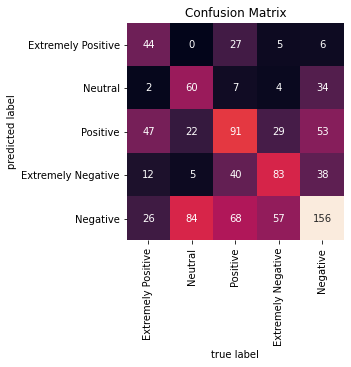

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_covid_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

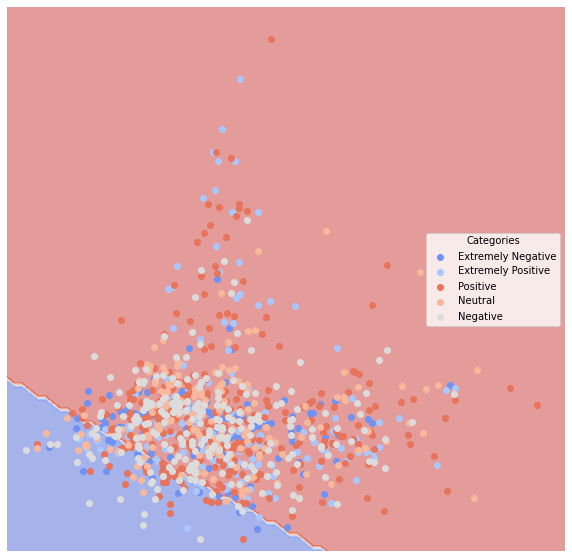

In [ ]:
lucem_illud.plotregions(clf_svm, test_covid_df)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/multilayerperceptron_network.png?raw=1) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_covid_df['vect'], axis=0), train_covid_df['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_covid_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Negative,0.138,0.632112,0.461538,0.236974,0.320611
Extremely Positive,0.168,0.648022,0.512195,0.296703,0.368421
Positive,0.371,0.564961,0.369565,0.321234,0.414634
Neutral,0.220,0.643908,0.392857,0.270944,0.432584
Negative,0.339,0.551916,0.302239,0.257070,0.347639


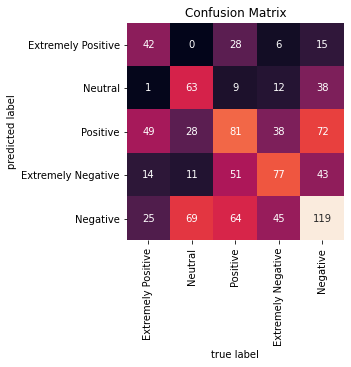

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_covid_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

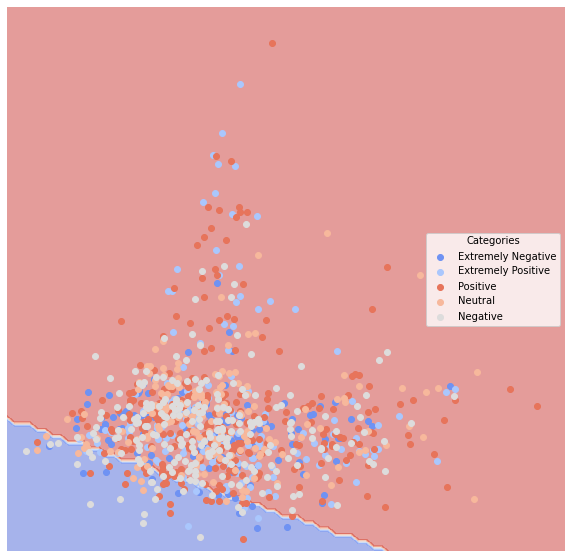

In [ ]:
lucem_illud.plotregions(clf_nn, test_covid_df)

It performs very well.